Imports

In [1]:
import numpy as np
import pandas as pd
import torch, math, random
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import torch, math, random
from statistics import mean

In [2]:
# Global Settings
random.seed(10)
all_agreements_percentages = []

Class Agent

In [3]:
import numpy as np
import pandas as pd
import torch, math, random

class Agent():
    def __init__(self):
        # Agent roles -> 0:A, 1:B
        self.role = None
        self.p_adding_signals = 0.1
        self.payoff = None
        self.P_A = 0.5
        self.P_B = 0.5
        self.V_A = 10
        self.V_B = 10
        self.signals = []
        self.sender = False
        self.receiver = False
        self.lr = 0.5
        self.chosen_sig = None
        self.p_exploration = 0.1
        self.confidence_threshhold = 0.25
        self.decay_signals = 0.99

    def pick_best_word(self, word_list):
        best_word = [word for word in word_list if word[-1] == max([sublist[-1] for sublist in word_list])]
        return best_word[0]

    def create_signal(self, rand_nr, counter, chosen_signal):
        if rand_nr < self.p_adding_signals:
            sig1 = "w" + str(counter)
            counter += 1
            guess_role = random.choice([0,1])
            generated_signal = [sig1, self.role, guess_role, 0.5]
            self.signals.append(generated_signal)
            chosen_signal = generated_signal
        return chosen_signal, counter

    def check_signals(self, chosen_signal):
        words_known = []
        for word in self.signals:
            if word[1] == self.role:
                words_known.append(word)
        if len(words_known) != 0:
            chosen_signal = self.pick_best_word(words_known)
        return chosen_signal
    
    def send_signal(self,counter):
        chosen_signal = None
        rand_nr = random.uniform(0,1)
        if self.sender:
            if len(self.signals) != 0:
                chosen_signal = self.check_signals(chosen_signal)
                if chosen_signal is not None:
                    return chosen_signal, counter

                rand_signal = self.create_signal(rand_nr, counter, chosen_signal)
                chosen_signal = rand_signal[0]
                counter = rand_signal[1]
                return chosen_signal, counter
            else:
                rand_signal = self.create_signal(rand_nr, counter, chosen_signal)
                chosen_signal = rand_signal[0]
                counter = rand_signal[1]
                return chosen_signal, counter
        return chosen_signal, counter

    def select_role(self):
        rand_nr = random.uniform(0,1)
        if self.receiver:
            if self.P_A > self.P_B:
                self.role = 0
            elif self.P_B > self.P_A:
                self.role = 1
            else:
                self.role = random.choice([0,1])
        elif self.sender:
            if rand_nr < self.p_exploration:
                if self.V_A > self.V_B:
                    self.role = 1
                elif self.V_B > self.V_A:
                    self.role = 0
                else:
                    self.role = random.choice([0,1])
            else:
                if self.V_A > self.V_B:
                    self.role = 0
                elif self.V_B > self.V_A:
                    self.role = 1
                else:
                    self.role = random.choice([0,1])
        else:
            self.role = random.choice([0,1])
        return self.role

    def decay_confidences(self):
        for elm1 in self.signals:
            elm1[-1] = elm1[-1] * self.decay_signals
    
    def remove_unused_signals(self):
        for elm1 in self.signals:
            if elm1[-1] < self.confidence_threshhold:
                self.signals.remove(elm1)
    
    def update_probabilities(self, chosen_signal):
        if self.receiver:
            if chosen_signal is not None:
                if len(self.signals) != 0:
                    for sigs in self.signals:
                        if chosen_signal[0] == sigs[0]:
                            self.chosen_sig = sigs
                            if sigs[2] == 0:
                                self.P_A = 1
                                self.P_B = 0
                                return True
                            else:
                                self.P_A = 0
                                self.P_B = 1
                                return True
                    rand_ind = random.choice([0,1])
                    update_list = [0,0]
                    update_list[rand_ind] = 1
                    self.P_A = update_list[0]
                    self.P_B = update_list[1]
                    guess_role = random.choice([0,1])
                    self.signals.append([chosen_signal[0], rand_ind, guess_role, 0.5])
                    self.chosen_sig = [chosen_signal[0], rand_ind, guess_role, 0.5]
                    return True
                else:
                    rand_ind = random.choice([0,1])
                    update_list = [0,0]
                    update_list[rand_ind] = 1
                    self.P_A = update_list[0]
                    self.P_B = update_list[1]
                    guess_role = random.choice([0,1])
                    self.signals.append([chosen_signal[0], rand_ind, guess_role, 0.5])
                    self.chosen_sig = [chosen_signal[0], rand_ind, guess_role, 0.5]
                    return True
        return True
    
    def update_values(self, reward):
        # Updating values of roles
        if self.role == 0:
            self.V_A += self.lr * (reward-self.V_A)
        elif self.role == 1:
            self.V_B += self.lr * (reward-self.V_B)

# Scenario 3 (Pick One Sender Each Round, Everyone Else Is Receiver)

The Game

In [4]:
results = []
agreements = []
nr_experiments = 30
for gameRound in range(nr_experiments):
    # Settings:
    nr_agents = 2
    time = 10000
    c_time = 1
    agents = []
    learning_rate = 0.5
    counter = 0

    # Create agents:
    for i in range(nr_agents):
        agents.append(Agent())
        agents[i].payoff = np.zeros(time)

    # The main framework that controls the game
    for t in range(1, time):
        selections_list = []
        # communication phase
        # Determine Sender and Recievers each round
        rand_index = random.choice(range(len(agents)))
        sender_agent = agents[rand_index]
        receiver_agents = [agent for agent in agents if agent != sender_agent]
        sender_agent.sender = True
        sender_agent.receiver = False
        sender_agent.select_role()
        selections_list.append(sender_agent.role)
        sent = sender_agent.send_signal(counter)
        chosen_signal = sent[0]
        counter = sent[1]
        for agent in receiver_agents:
            agent.sender = False
            agent.receiver = True
            agent.update_probabilities(chosen_signal)
            agent.select_role()
            selections_list.append(agent.role)
        payoffs_list = np.zeros(nr_agents)

        # Check signals every 2 rounds
        if t%2 == 0:
            for agent in agents:
                agent.remove_unused_signals()

        # Calculate payoffs
        # To change the Games, simply uncomment the corresponding lines and comment the othe rules
    #################################################################################################
        # Games 1: All agents must have the same roles
        for i in range(len(agents)):
            if all(roles == selections_list[0] for roles in selections_list):
                payoffs_list[i] += 5
            else:            
                payoffs_list[i] += 0
    #################################################################################################
        # # Games 2: All agents must not have the same roles
        # for i in range(len(agents)):
        #     if not all(roles == selections_list[0] for roles in selections_list):
        #         payoffs_list[i] += 5
        #     else:            
        #         payoffs_list[i] += 0
    #################################################################################################
        # # Games 3: Sender must have role A (0), Receivers must have role B (1)
        # recievers_roles_list = list(receiver.role for receiver in receiver_agents)
        # for i in range(len(agents)):
        #     if (sender_agent.role == 0) and (recievers_roles_list.count(1) == len(recievers_roles_list)):
        #         payoffs_list[i] += 5
        #     else:            
        #         payoffs_list[i] += 0
    #################################################################################################

        # distribute rewards
        for i in range(nr_agents):
            agents[i].payoff[t] = payoffs_list[i]
            agents[i].update_values(agents[i].payoff[t])
            agents[i].decay_confidences()
            agents[i].sender = False
            agents[i].receiver = False
    
        # Check if communication was successful
        if chosen_signal is not None:
            for elm1 in sender_agent.signals:
                if elm1 == chosen_signal:
                    elm1[-1] += learning_rate * (sender_agent.payoff[t] - elm1[-1])
                    if elm1[-1] < 0:
                        elm1[-1] = 0
                    elif elm1[-1] > 1:
                        elm1[-1] = 1
            for agent in receiver_agents:
                for elm2 in agent.signals:
                    if elm2 == agent.chosen_sig:
                        elm2[-1] += learning_rate * (agent.payoff[t] - elm2[-1])
                        if elm2[-1] < 0:
                            elm2[-1] = 0
                        elif elm2[-1] > 1:
                            elm2[-1] = 1
    
    # Checking the semantic similarity between all agents
    # Note: to match the corresponding Game, uncomment the corresponding section and comment the others
    #################################################################################################
    # Matching with Game 1, 3:
    successful = []
    for agent in receiver_agents:
        signal_list = [agent.signals, sender_agent.signals]
        for x,y in zip(*signal_list):
            if (x[-1] > 0.5) and (y[-1] > 0.5):
                successful.append((x[0]==y[0]) and (x[1]==y[1]) and (x[2]==y[2]))
    for agent in agents:
        if len(agent.signals) == 0:
            successful.append(False)
    #################################################################################################
    # # Matching with Game 2:
    # successful = []
    # for agent in receiver_agents:
    #     signal_list = [agent.signals, sender_agent.signals]
    #     for x,y in zip(*signal_list):
    #         if (x[-1] > 0.5) and (y[-1] > 0.5):
    #             successful.append((x[0]==y[0]) and not(x[1]==y[1]) and not(x[2]==y[2]))
    # for agent in agents:
    #     if len(agent.signals) == 0:
    #         successful.append(False)
    #################################################################################################
    
    f5 = open("Scenario3_results.txt", "a")
    print("\n\nRound {}".format(round), sep=',', file=f5)
    print("Game {}".format(t), sep=',', file=f5)
    for i in range(len(agents)):
        print("agent[{}] signals is:{}".format(i, agents[i].signals), sep=',', file=f5)
    f5.close()

    result = []
    for agent in agents:
        result.append(agent.payoff)

    results.append(result)
    if all(x == True for x in successful):
        agreed = True
    else:
        agreed = False
    agreements.append(agreed)

In [5]:
results_df = pd.DataFrame(results)
sum_df = 0
for i in range(len(results_df.columns)):
    sum_df += results_df[i]
avg_df = (sum_df / len(results_df.columns)).mean()
agreement_percent = (agreements.count(True) / len(agreements) ) * 100
all_agreements_percentages.append(agreement_percent)
print("the percentage of the games that had agreement is:{}%".format(agreement_percent))

the percentage of the games that had agreement is:100.0%


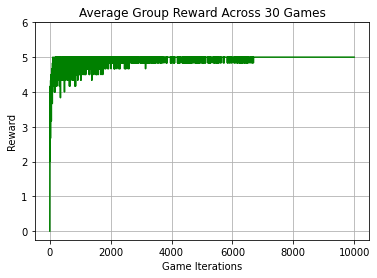

In [6]:
# The plot
plt.plot(avg_df, color = "green")
plt.title('Average Group Reward Across 30 Games')
plt.xlabel('Game Iterations')
plt.yticks([0,1,2,3,4,5,6])
plt.ylabel('Reward')
plt.grid()
plt.show()

# Scenario 4 (Pick A Pair Of Sender And Receiver Each Round)

The Game

In [7]:
results = []
agreements = []
payoffsTrendRounds = []
nr_experiments = 30
for gameRound in range(nr_experiments):
    # Settings:
    nr_agents = 2
    time = 10000
    c_time = 1
    agents = []
    learning_rate = 0.5
    counter = 0
    pairs1 = np.zeros(time)
    pairs2 = np.zeros(time)

    # Create agents:
    for i in range(nr_agents):
        agents.append(Agent())
        agents[i].payoff = np.zeros(time)

    # The main framework that controls the game
    for t in range(1, time):
        selections_list = []
        # communication phase
        # Determine Pairs of Sender and Recievers once each game
        rand_index_sender = random.choice(range(len(agents)))
        sender_agent = agents[rand_index_sender]
        receiver_agents = [agent for agent in agents if agent != sender_agent]
        receiver_agent = random.choice(receiver_agents)
        sender_agent.sender = True
        sender_agent.receiver = False
        receiver_agent.sender = False
        receiver_agent.receiver = True
        sender_agent.select_role()
        selections_list.append(sender_agent.role)
        sent = sender_agent.send_signal(counter)
        chosen_signal = sent[0]
        counter = sent[1]
        receiver_agent.update_probabilities(chosen_signal)
        receiver_agent.select_role()
        picked_agents = [sender_agent, receiver_agent]
        selections_list.append(receiver_agent.role)
        payoffs_list = np.zeros(len(picked_agents))
    
        # Check signals every 2 rounds
        if t%2 == 0:
            for agent in agents:
                agent.remove_unused_signals()
        
        # Calculate payoffs
        # To change the Games, simply uncomment the corresponding lines and comment the othe rules
    #################################################################################################
        # # Game 1: All agents must have the same roles
        for i in range(len(picked_agents)):
            if all(roles == selections_list[0] for roles in selections_list):
                payoffs_list[i] += 5
            else:            
                payoffs_list[i] += 0
    #################################################################################################
        # # Game 2: All agents must not have the same roles
        # for i in range(len(picked_agents)):
        #     if not all(roles == selections_list[0] for roles in selections_list):
        #         payoffs_list[i] += 5
        #     else:            
        #         payoffs_list[i] += 0
    #################################################################################################
        # # Game 3: Sender must have role A (0), Receiver must have role B (1)
        # for i in range(len(picked_agents)):
        #     if (sender_agent.role == 0) and (receiver_agent.role == 1):
        #         payoffs_list[i] += 5
        #     else:            
        #         payoffs_list[i] += 0
    #################################################################################################

        # distribute rewards
        for i in range(len(picked_agents)):
            picked_agents[i].payoff[t] = payoffs_list[i]
            picked_agents[i].update_values(picked_agents[i].payoff[t])
            picked_agents[i].decay_confidences()
            picked_agents[i].sender = False
            picked_agents[i].receiver = False
        
        # Check if communication was successful
        if chosen_signal is not None:
            for elm1 in sender_agent.signals:
                if elm1 == chosen_signal:
                    elm1[-1] += learning_rate * (sender_agent.payoff[t] - elm1[-1])
                    if elm1[-1] < 0:
                        elm1[-1] = 0
                    elif elm1[-1] > 1:
                        elm1[-1] = 1
            for elm2 in receiver_agent.signals:
                if elm2 == receiver_agent.chosen_sig:
                    elm2[-1] += learning_rate * (receiver_agent.payoff[t] - elm2[-1])
                    if elm2[-1] < 0:
                        elm2[-1] = 0
                    elif elm2[-1] > 1:
                        elm2[-1] = 1
        pairs1[t] = payoffs_list[0]
        pairs2[t] = payoffs_list[1]


    # Checking the semantic similarity between all agents
    # Note: to match the corresponding Game, uncomment the corresponding section and comment the others
    #################################################################################################
    # Matching with Game 1, 3:
    successful = []
    for agent in receiver_agents:
        signal_list = [agent.signals, sender_agent.signals]
        for x,y in zip(*signal_list):
            if (x[-1] > 0.5) and (y[-1] > 0.5):
                successful.append((x[0]==y[0]) and (x[1]==y[1]) and (x[2]==y[2]))
    for agent in agents:
        if len(agent.signals) == 0:
            successful.append(False)
    #################################################################################################
    # # Matching with Game 2:
    # successful = []
    # for agent in receiver_agents:
    #     signal_list = [agent.signals, sender_agent.signals]
    #     for x,y in zip(*signal_list):
    #         if (x[-1] > 0.5) and (y[-1] > 0.5):
    #             successful.append((x[0]==y[0]) and not(x[1]==y[1]) and not(x[2]==y[2]))
    # for agent in agents:
    #     if len(agent.signals) == 0:
    #         successful.append(False)
    #################################################################################################

    f5 = open("Scenari4_results.txt", "a")
    print("\n\nRound {}".format(gameRound), sep=',', file=f5)
    print("Game {}".format(t), sep=',', file=f5)
    for i in range(len(agents)):
        print("agent[{}] signals is:{}".format(i, agents[i].signals), sep=',', file=f5)
    f5.close()

    result = []
    df_columns = []
    payoffsTrendRounds.append([pairs1, pairs2])
    for i in range(len(agents)):
        result.append(agents[i].payoff)
        df_columns.append('Agent {}'.format(i))
    results.append(result)
    if all(x == True for x in successful):
        agreed = True
    else:
        agreed = False
    agreements.append(agreed)

In [8]:
# results_df = pd.DataFrame(results, columns = df_columns)
payoffs_df = pd.DataFrame(payoffsTrendRounds, columns = {"Pairs 1", "Pairs 2"})
avg_df = ((payoffs_df["Pairs 1"] + payoffs_df["Pairs 2"]) / 2).mean()
agreement_percent = (agreements.count(True) / len(agreements) ) * 100
all_agreements_percentages.append(agreement_percent)
print("the percentage of the games that had agreement is:{}%".format(agreement_percent))

the percentage of the games that had agreement is:96.66666666666667%


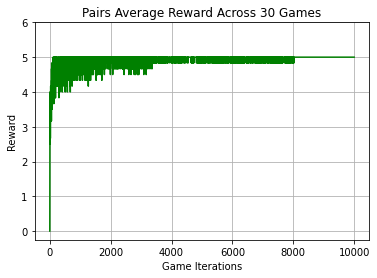

In [9]:
# The plot
plt.plot(avg_df, color = "green")
plt.title('Pairs Average Reward Across 30 Games')
plt.xlabel('Game Iterations')
plt.yticks([0,1,2,3,4,5,6])
plt.ylabel('Reward')
plt.grid()
plt.show()

# Scenario 5 (Sender Adjusts The Signal Based On Receiver's Action)

In [10]:
results = []
agreements = []
payoffsTrendRounds = []
nr_experiments = 30
for gameRound in range(nr_experiments):
    # Settings:
    nr_agents = 2
    time = 10000
    c_time = 1
    agents = []
    learning_rate = 0.5
    counter = 0
    pairs1 = np.zeros(time)
    pairs2 = np.zeros(time)

    # Create agents:
    for i in range(nr_agents):
        agents.append(Agent())
        agents[i].payoff = np.zeros(time)

    # The main framework that controls the game
    for t in range(1, time):
        selections_list = []
        # communication phase
        # Determine Pairs of Sender and Recievers once each game
        rand_index_sender = random.choice(range(len(agents)))
        sender_agent = agents[rand_index_sender]
        receiver_agents = [agent for agent in agents if agent != sender_agent]
        receiver_agent = random.choice(receiver_agents)
        sender_agent.sender = True
        sender_agent.receiver = False
        receiver_agent.sender = False
        receiver_agent.receiver = True
        sender_agent.select_role()
        selections_list.append(sender_agent.role)
        sent = sender_agent.send_signal(counter)
        chosen_signal = sent[0]
        counter = sent[1]
        receiver_agent.update_probabilities(chosen_signal)
        receiver_agent.select_role()
        picked_agents = [sender_agent, receiver_agent]
        selections_list.append(receiver_agent.role)
        payoffs_list = np.zeros(len(picked_agents))
    
        # Check signals every 2 rounds
        if t%2 == 0:
            for agent in agents:
                agent.remove_unused_signals()
        
        # Calculate payoffs
        # To change the Game, simply uncomment the corresponding lines and comment the othe rules
    #################################################################################################
        # Game 1: All agents must have the same roles
        for i in range(len(picked_agents)):
            if all(roles == selections_list[0] for roles in selections_list):
                payoffs_list[i] += 5
            else:            
                payoffs_list[i] += 0
    #################################################################################################
        # # Game 2: All agents must not have the same roles
        # for i in range(len(picked_agents)):
        #     if not all(roles == selections_list[0] for roles in selections_list):
        #         payoffs_list[i] += 5
        #     else:            
        #         payoffs_list[i] += 0
    #################################################################################################
        # # Game 3: Sender must have role A (0), Receiver must have role B (1)
        # for i in range(len(picked_agents)):
        #     if (sender_agent.role == 0) and (receiver_agent.role == 1):
        #         payoffs_list[i] += 5
        #     else:            
        #         payoffs_list[i] += 0
    #################################################################################################

        # distribute rewards
        for i in range(len(picked_agents)):
            picked_agents[i].payoff[t] = payoffs_list[i]
            picked_agents[i].update_values(picked_agents[i].payoff[t])
            picked_agents[i].decay_confidences()
            picked_agents[i].sender = False
            picked_agents[i].receiver = False
        
        # Check if communication was successful
        if chosen_signal is not None:
            for elm1 in sender_agent.signals:
                if elm1 == chosen_signal:
                    elm1[-1] += learning_rate * (sender_agent.payoff[t] - elm1[-1])
                    # Observe the action of receiver and adjust the sent signal
                    if elm1[2] != receiver_agent.chosen_sig[2]:
                        elm1[-1] -= 0.1

                    if elm1[-1] < 0:
                        elm1[-1] = 0
                    if elm1[-1] > 1:
                        elm1[-1] = 1

            for elm2 in receiver_agent.signals:
                if elm2 == receiver_agent.chosen_sig:
                    elm2[-1] += learning_rate * (receiver_agent.payoff[t] - elm2[-1])
                    if elm2[-1] < 0:
                        elm2[-1] = 0
                    elif elm2[-1] > 1:
                        elm2[-1] = 1
            
        pairs1[t] = payoffs_list[0]
        pairs2[t] = payoffs_list[1]

    # Checking the semantic similarity between all agents
    # Note: to match the corresponding Game, uncomment the corresponding section and comment the others
    #################################################################################################
    # Matching with Game 1, 3:
    successful = []
    for agent in receiver_agents:
        signal_list = [agent.signals, sender_agent.signals]
        for x,y in zip(*signal_list):
            if (x[-1] > 0.5) and (y[-1] > 0.5):
                successful.append((x[0]==y[0]) and (x[1]==y[1]) and (x[2]==y[2]))
    for agent in agents:
        if len(agent.signals) == 0:
            successful.append(False)
    #################################################################################################
    # # Matching with Game 2:
    # successful = []
    # for agent in receiver_agents:
    #     signal_list = [agent.signals, sender_agent.signals]
    #     for x,y in zip(*signal_list):
    #         if (x[-1] > 0.5) and (y[-1] > 0.5):
    #             successful.append((x[0]==y[0]) and not(x[1]==y[1]) and not(x[2]==y[2]))
    # for agent in agents:
    #     if len(agent.signals) == 0:
    #         successful.append(False)
    #################################################################################################

    f5 = open("Scenario5_results.txt", "a")
    print("\n\nRound {}".format(gameRound), sep=',', file=f5)
    print("Game {}".format(t), sep=',', file=f5)
    for i in range(len(agents)):
        print("agent[{}] signals is:{}".format(i, agents[i].signals), sep=',', file=f5)
    f5.close()

    result = []
    df_columns = []
    payoffsTrendRounds.append([pairs1, pairs2])
    for i in range(len(agents)):
        result.append(agents[i].payoff)
        df_columns.append('Agent {}'.format(i))
    results.append(result)
    if all(x == True for x in successful):
        agreed = True
    else:
        agreed = False
    agreements.append(agreed)

In [11]:
# results_df = pd.DataFrame(results, columns = df_columns)
payoffs_df = pd.DataFrame(payoffsTrendRounds, columns = {"Pairs 1", "Pairs 2"})
avg_df = ((payoffs_df["Pairs 1"] + payoffs_df["Pairs 2"]) / 2).mean()
agreement_percent = (agreements.count(True) / len(agreements) ) * 100
all_agreements_percentages.append(agreement_percent)
print("the percentage of the games that had agreement is:{}%".format(agreement_percent))

the percentage of the games that had agreement is:96.66666666666667%


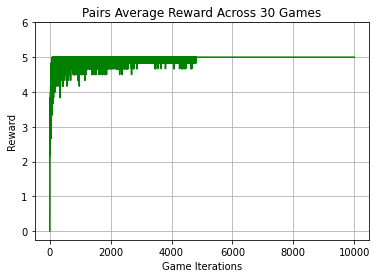

In [12]:
# The plot
plt.plot(avg_df, color = "green")
plt.title('Pairs Average Reward Across 30 Games')
plt.xlabel('Game Iterations')
plt.yticks([0,1,2,3,4,5,6])
plt.ylabel('Reward')
plt.grid()
plt.show()

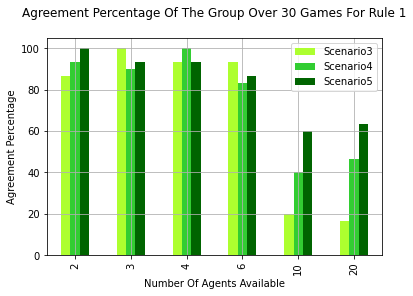

In [14]:
# The Dataframe
agreements_df = pd.read_csv("agreements.txt", sep=" ")
# The plot
ax = agreements_df.plot(x="nr_agents", y=["Scenario3", "Scenario4", "Scenario5"], kind="bar", color=['greenyellow', 'limegreen', 'darkgreen'])
plt.gca().legend()
plt.title('Agreement Percentage Of The Group Over 30 Games For Rule 1\n')
plt.xlabel('Number Of Agents Available')
plt.ylabel('Agreement Percentage')
plt.grid()
plt.show()